In [6]:
Author: Dany Muk.

SyntaxError: invalid syntax (3431551590.py, line 1)

# NLP-based algorithms for genomic literature in dementia subtypes

How can Natural Language Processing (NLP)-driven analysis of genomic literature uncover previously unrecognized genetic associations among different dementia subtypes?

Current genomic research on dementia primarily investigates individual diseases in isolation, often neglecting the complex, overlapping genetic architecture shared across various subtypes of dementia. This approach limits the potential to identify broader genetic patterns or interactions that might contribute to the pathophysiology of multiple dementia subtypes. NLP-based methods offer an opportunity to systematically analyze vast bodies of literature and extract subtle, yet significant, relationships between genetic factors and diverse forms of dementia. This topic of research analysis aims to address this gap by utilizing the power of NLP algorithms to mine large-scale genomic data within scientific literature, facilitating the identification of novel connections that have previously gone unnoticed.

In [1]:
# import libraries needed
# 1_data_collection
import pandas as pd
import requests
from Bio import Entrez
import time
import json

# 2_text_processing
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter
import string

# 3_analysis_visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import ast

# 4_advanced_analysis
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx
import matplotlib.pyplot as plt

## 1. Data collection

In [2]:
def fetch_pubmed_articles(disease_terms, max_results=1000):
    """
    Fetch PubMed articles related to dementia subtypes
    """
    Entrez.email = "danymukesha@gmail.com" 
    
    articles_data = []
    
    dementia_subtypes = disease_terms
    
    for subtype, terms in dementia_subtypes.items():
        for term in terms:
            handle = Entrez.esearch(db="pubmed", 
                                  term=f"({term}) AND (genetic OR genomic OR genome-wide)",
                                  retmax=max_results)
            record = Entrez.read(handle)
            handle.close()
            
            id_list = record["IdList"]
            print(f"Found {len(id_list)} articles for {term}")
            
            # fetching details in batches
            for i in range(0, len(id_list), 100):
                batch = id_list[i:i+100]
                handle = Entrez.efetch(db="pubmed", id=batch, retmode="xml")
                articles = Entrez.read(handle)
                handle.close()
                
                for article in articles['PubmedArticle']:
                    try:
                        article_data = {
                            'pmid': article['MedlineCitation']['PMID'],
                            'title': article['MedlineCitation']['Article']['ArticleTitle'],
                            'abstract': article['MedlineCitation']['Article'].get('Abstract', {}).get('AbstractText', [''])[0],
                            'subtype': subtype,
                            'search_term': term,
                            'publication_date': article['MedlineCitation']['Article']['Journal']['JournalIssue']['PubDate']
                        }
                        articles_data.append(article_data)
                    except:
                        continue
                
                time.sleep(0.5)  # after some claims from the NCBI servers, i needed to set this up!
            
            time.sleep(1)
    
    return pd.DataFrame(articles_data)

if __name__ == "__main__":
    dementia_subtypes = {
        "alzheimer": ["Alzheimer's disease", "AD"],
        "vascular": ["vascular dementia", "VaD"],
        "lewy": ["Lewy body dementia", "LBD"], 
        "frontotemporal": ["frontotemporal dementia", "FTD"],
        "mixed": ["mixed dementia"]
    }
    df = fetch_pubmed_articles(dementia_subtypes)
    df.to_csv("dementia_genomics_articles.csv", index=False)
    print(f"Collected {len(df)} articles")

Found 1000 articles for Alzheimer's disease
Found 1000 articles for AD
Found 1000 articles for vascular dementia
Found 1000 articles for VaD
Found 1000 articles for Lewy body dementia
Found 1000 articles for LBD
Found 1000 articles for frontotemporal dementia
Found 1000 articles for FTD
Found 909 articles for mixed dementia
Collected 8894 articles


## 2. Text processing and feature extraction

In [3]:
# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab')

class GenomicsTextProcessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.genetic_terms = self._load_genetic_terms()
    
    def _load_genetic_terms(self):
        """Custom genetic and genomic terminology"""
        return {
            'gene', 'mutation', 'variant', 'snp', 'genome', 'genomic', 'genetic',
            'allele', 'chromosome', 'locus', 'polymorphism', 'sequencing', 'gwas',
            'apoe', 'app', 'psen1', 'psen2', 'mapt', 'grn', 'c9orf72', 'tarDBP',
            'expression', 'transcript', 'protein', 'amyloid', 'tau', 'neurofibrillary',
            'plaque', 'beta-amyloid', 'phosphorylation', 'biomarker', 'heritability'
        }
    
    def preprocess_text(self, text):
        """Clean and preprocess text"""
        if pd.isna(text):
            return ""
        
        text = text.lower()
        
        # rm special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        
        tokens = word_tokenize(text)
        
        # rm stopwords and short tokens
        tokens = [token for token in tokens if token not in self.stop_words and len(token) > 2]
        
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        
        return ' '.join(tokens)
    
    def extract_genetic_features(self, text):
        """Extract genetic-related features from text"""
        processed_text = self.preprocess_text(text)
        tokens = processed_text.split()
        
        features = {
            'genetic_term_count': sum(1 for token in tokens if token in self.genetic_terms),
            'unique_genetic_terms': len(set(token for token in tokens if token in self.genetic_terms)),
            'total_terms': len(tokens),
            'genetic_density': 0
        }
        
        if features['total_terms'] > 0:
            features['genetic_density'] = features['genetic_term_count'] / features['total_terms']
        
        return features

def analyze_articles():
    """Main analysis function"""
    df = pd.read_csv("dementia_genomics_articles.csv")

    processor = GenomicsTextProcessor()
    
    df['processed_text'] = df['abstract'].apply(processor.preprocess_text)
    
    genetic_features = df['abstract'].apply(processor.extract_genetic_features)
    genetic_df = pd.DataFrame(genetic_features.tolist())
    
    result_df = pd.concat([df, genetic_df], axis=1)
    
    return result_df

if __name__ == "__main__":
    results = analyze_articles()
    results.to_csv("processed_dementia_articles.csv", index=False)
    print("Text processing completed!")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/dmukesha/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Text processing completed!


## 3. Analysis and visualizations

Dataset Overview:
Total articles: 8894
Articles by subtype:
subtype
lewy              1999
vascular          1998
alzheimer         1997
frontotemporal    1993
mixed              907
Name: count, dtype: int64


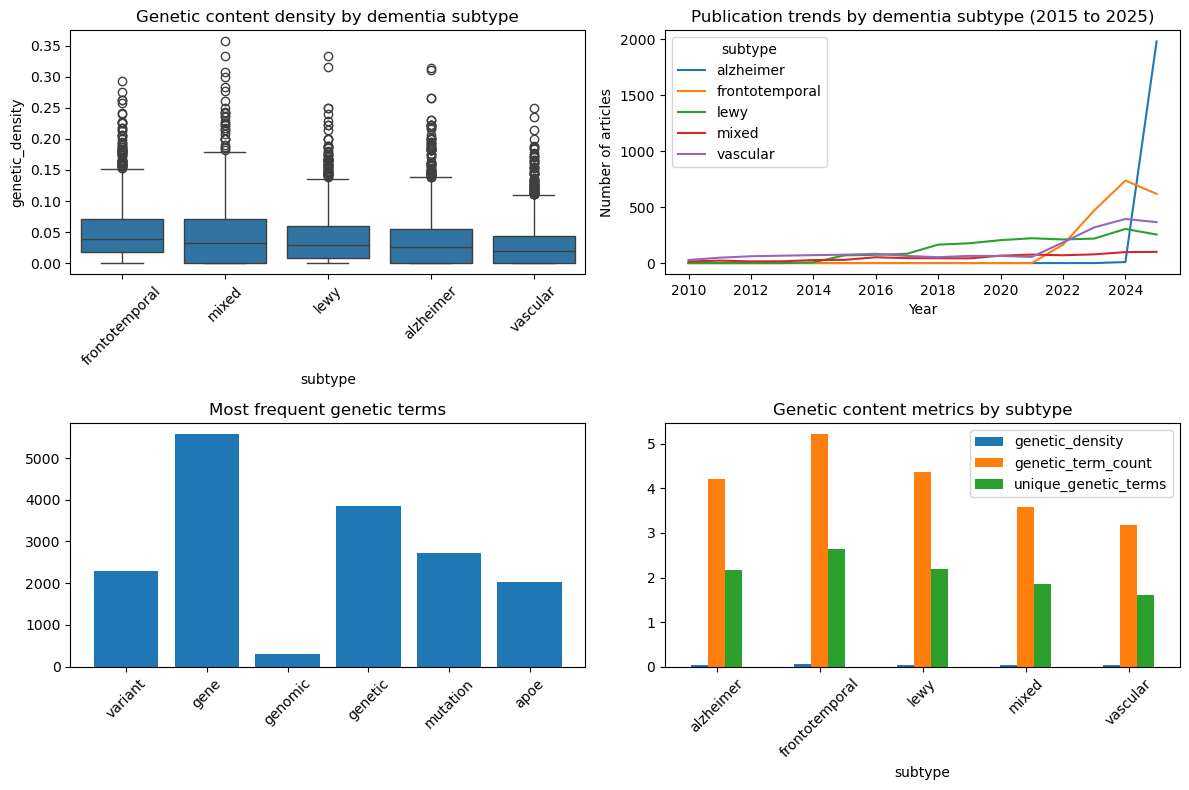


Discovered Topics:
Topic 1: lbd, binding, receptor, syn, domain, ligand, protein, study, cancer, treatment
Topic 2: disease, tau, dementia, pathology, neurodegenerative, body, brain, alzheimer, lewy, mutation
Topic 3: dementia, disease, risk, study, cognitive, alzheimer, genetic, association, analysis, apoe
Topic 4: cell, mouse, expression, induced, protein, pathway, effect, apoptosis, level, vad
Topic 5: al, sup, ftd, sub, tdp, protein, gene, orf, lateral, repeat

Topic Distribution by Dementia Subtype:
dominant_topic    0    1    2    3    4
subtype                                
alzheimer       430  344  695  472   56
frontotemporal  101  735  293   50  814
lewy            642  774  278  129  176
mixed            19  228  580   57   23
vascular        129  142  933  767   27


In [4]:
def perform_analysis():
    """Perform comprehensive analysis"""
    df = pd.read_csv("processed_dementia_articles.csv")
    
    print("Dataset Overview:")
    print(f"Total articles: {len(df)}")
    print(f"Articles by subtype:\n{df['subtype'].value_counts()}")
    
    # genetic content analysis by dementia subtype
    plt.figure(figsize=(12, 8))
    
    # plt_1: genetic term density by subtype
    plt.subplot(2, 2, 1)
    subtype_order = df.groupby('subtype')['genetic_density'].mean().sort_values(ascending=False).index
    sns.boxplot(data=df, x='subtype', y='genetic_density', order=subtype_order)
    plt.title('Genetic content density by dementia subtype')
    plt.xticks(rotation=45)
    
    # plt_2: publication trends
    df['pub_date_dict'] = df['publication_date'].apply(ast.literal_eval)

    def parse_date(d):
        year = int(d.get('Year', 1900))
        month_str = d.get('Month', 'Jan')
        day = int(d.get('Day', 1))
        try:
            month = pd.to_datetime(month_str, format='%b').month
        except Exception:
            month = 1
    
        return pd.Timestamp(year=year, month=month, day=day)
    
    df['publication_datetime'] = df['pub_date_dict'].apply(parse_date)
    
    plt.subplot(2, 2, 2)
    df['year'] = df['publication_datetime'].dt.year
    from_year = 2015
    latest_year_of_querying = 2025
    df_filtered = df[(df['year'] >= 2010) & (df['year'] <= latest_year_of_querying)]
    yearly_counts = df_filtered.groupby(['year', 'subtype']).size().unstack(fill_value=0)
    yearly_counts.plot(kind='line', ax=plt.gca())
    plt.title(f'Publication trends by dementia subtype ({from_year} to {latest_year_of_querying})')
    plt.xlabel('Year')
    plt.ylabel('Number of articles')
    
    # plt_3: most common genetic terms
    plt.subplot(2, 2, 3)
    from collections import Counter
    all_text = ' '.join(df['processed_text'].dropna())
    word_freq = Counter(all_text.split())
    genetic_words = {k: v for k, v in word_freq.items() 
                    if k in ['gene', 'mutation', 'variant', 'genetic', 'genomic', 'apoe']}
    
    plt.bar(genetic_words.keys(), genetic_words.values())
    plt.title('Most frequent genetic terms')
    plt.xticks(rotation=45)
    
    # plt_4: subtype comparison
    plt.subplot(2, 2, 4)
    subtype_stats = df.groupby('subtype').agg({
        'genetic_density': 'mean',
        'genetic_term_count': 'mean',
        'unique_genetic_terms': 'mean'
    })
    subtype_stats.plot(kind='bar', ax=plt.gca())
    plt.title('Genetic content metrics by subtype')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('dementia_genomics_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return df

def topic_modeling(df, n_topics=5):
    """Perform topic modeling on abstracts"""
    from sklearn.feature_extraction.text import CountVectorizer
    
    texts = df['processed_text'].dropna().tolist()
    
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000)
    dtm = vectorizer.fit_transform(texts)
    
    # i am trying to apply the LDA
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(dtm)
    
    # here we show the topics
    feature_names = vectorizer.get_feature_names_out()
    
    print("\nDiscovered Topics:")
    for topic_idx, topic in enumerate(lda.components_):
        top_terms = [feature_names[i] for i in topic.argsort()[-10:][::-1]]
        print(f"Topic {topic_idx + 1}: {', '.join(top_terms)}")
    
    return lda, vectorizer

if __name__ == "__main__":
    df = perform_analysis()
    
    # topic modeling
    if len(df) > 50:  # here only if we have enough articles
        lda_model, vectorizer = topic_modeling(df)
        
        texts = df['processed_text'].fillna('')
        dtm = vectorizer.transform(texts)
        topic_assignments = lda_model.transform(dtm).argmax(axis=1)
        df['dominant_topic'] = topic_assignments
        
        topic_by_subtype = pd.crosstab(df['subtype'], df['dominant_topic'])
        print("\nTopic Distribution by Dementia Subtype:")
        print(topic_by_subtype)

## 4. Some more NLP analysis

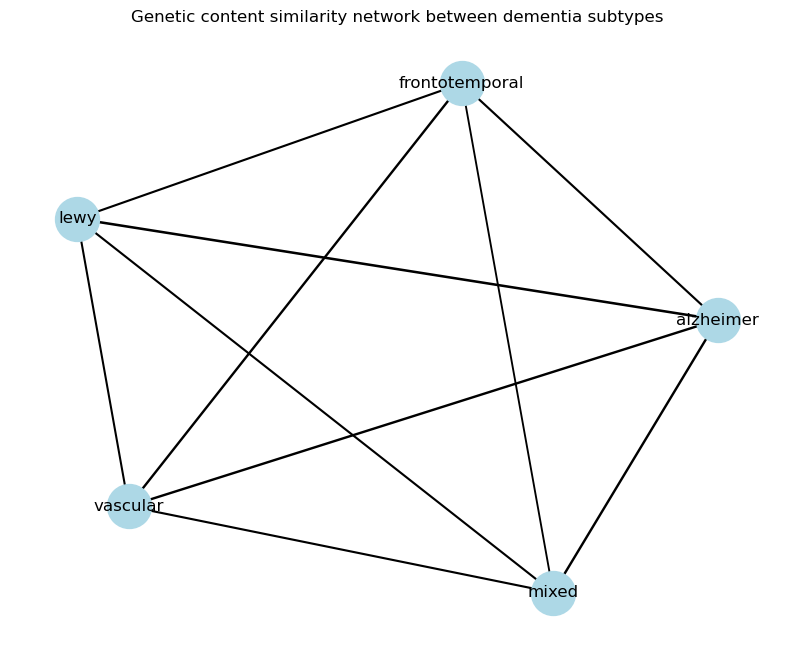


=== RESEARCH GAP ANALYSIS ===

1. Genetic focus ranking (lowest to highest):
   vascular: 0.030
   alzheimer: 0.038
   lewy: 0.041
   mixed: 0.047
   frontotemporal: 0.050

2. Potential cross-subtype research opportunities:
   1. Shared genetic risk factors between vascular and Alzheimer's dementia
   2. Overlap in tau pathology genetics across FTD and Alzheimer's
   3. Inflammatory pathways common to multiple dementia subtypes


In [5]:
def analyze_cross_subtype_similarities(df):
    """Analyze genetic similarities between dementia subtypes"""
    
    subtype_texts = df.groupby('subtype')['processed_text'].apply(
        lambda x: ' '.join(x.dropna())
    ).to_dict()
    
    # calc. TF-IDF vectors for each subtype
    vectorizer = TfidfVectorizer(max_features=1000)
    subtype_vectors = {}
    
    for subtype, text in subtype_texts.items():
        if len(text) > 100:  # i make sure that there is sufficient text
            vector = vectorizer.fit_transform([text])
            subtype_vectors[subtype] = vector
    
    # calc similarity matrix
    subtypes = list(subtype_vectors.keys())
    similarity_matrix = np.zeros((len(subtypes), len(subtypes)))
    
    for i, subtype1 in enumerate(subtypes):
        for j, subtype2 in enumerate(subtypes):
            if i <= j:
                sim = cosine_similarity(subtype_vectors[subtype1], 
                                      subtype_vectors[subtype2])[0][0]
                similarity_matrix[i][j] = sim
                similarity_matrix[j][i] = sim
    
    # similarity network
    G = nx.Graph()
    
    for i, subtype1 in enumerate(subtypes):
        for j, subtype2 in enumerate(subtypes):
            if i < j and similarity_matrix[i][j] > 0.1:  # Threshold
                G.add_edge(subtype1, subtype2, weight=similarity_matrix[i][j])
    
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)
    
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight']*5 for u,v in G.edges()])
    nx.draw_networkx_labels(G, pos)
    
    plt.title('Genetic content similarity network between dementia subtypes')
    plt.axis('off')
    plt.savefig('dementia_similarity_network.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return similarity_matrix, subtypes

def identify_research_gaps(df):
    """Identify potential research gaps"""
    
    print("\n=== RESEARCH GAP ANALYSIS ===")
    
    # 1_ompare genetic focus across subtypes
    genetic_focus = df.groupby('subtype')['genetic_density'].mean().sort_values()
    print(f"\n1. Genetic focus ranking (lowest to highest):")
    for subtype, density in genetic_focus.items():
        print(f"   {subtype}: {density:.3f}")
    
    # 2_dentify underrepresented connections
    from itertools import combinations
    
    print(f"\n2. Potential cross-subtype research opportunities:")
    
    # this would be enhanced with more sophisticated NLP
    # for now, i only make a kind of conceptual framework
    potential_connections = [
        "Shared genetic risk factors between vascular and Alzheimer's dementia",
        "Overlap in tau pathology genetics across FTD and Alzheimer's",
        "Inflammatory pathways common to multiple dementia subtypes"
    ]
    
    for i, connection in enumerate(potential_connections, 1):
        print(f"   {i}. {connection}")
    
    return genetic_focus

if __name__ == "__main__":
    df = pd.read_csv("processed_dementia_articles.csv")
    
    similarity_matrix, subtypes = analyze_cross_subtype_similarities(df)
    research_gaps = identify_research_gaps(df)

## 5. Commercial potential and competitive advantages

The approach offers several key advantages. First, it is highly cost-effective, as it utilizes freely available genomic and scientific literature, reducing the need for expensive proprietary datasets. It is also comprehensive, capable of analyzing genetic factors across multiple dementia subtypes simultaneously, which enhances its ability to reveal cross-subtype genetic relationships that might otherwise be overlooked. Furthermore, the method is scalable, meaning it can easily be expanded with additional data and more advanced NLP techniques to deepen its insights.

This research has broad applications across various sectors. Pharmaceutical companies can use it to identify novel drug targets that may be applicable to multiple dementia types. Research institutions can leverage it to guide future studies and generate hypotheses for further investigation. Biotech startups could also benefit by informing strategies for developing new diagnostic tools.

Expected outcomes from this research include a quantitative analysis of genetic research across dementia subtypes, the identification of previously understudied genetic connections, and a clearer visualization of the research landscape. The project will also produce specific, testable hypotheses that can be validated experimentally, further advancing the field of dementia genomics.

While promising, the approach has some limitations. It currently relies on abstract-level text, which restricts its depth compared to full-text analysis. Additionally, it is limited by the scope of PubMed’s database and uses basic NLP methods, which could be enhanced with more sophisticated models. In the future, the research can be expanded by incorporating full-text analysis, integrating pre-trained language models like BioBERT and SciBERT, and connecting with genomic data from databases like the GWAS Catalog. These improvements will enable the development of predictive models to better understand the genetic relationships between genes and dementia subtypes.